In [2]:
"""IMPORT MODULES"""

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px

sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahlaam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ahlaam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
#import dataset
df = pd.read_csv('https://raw.githubusercontent.com/gabrielpreda/covid-19-tweets/master/covid19_tweets.csv')
df.shape

(179108, 13)

In [4]:
#keep required columns
needed_columns = ['user_name','date','text']
df = df[needed_columns]
df.head()

,user_name,date,text
0,ᏉᎥ☻լꂅϮ,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,Tom Basile 🇺🇸,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...


In [7]:
#change type - assign number to name
df.user_name = df.user_name.astype('category')
df.user_name = df.user_name.cat.codes

#convert data to datetime
df.date = pd.to_datetime(df.date).dt.date
df.head()

,user_name,date,text
0,89755,2020-07-25,If I smelled the scent of hand sanitizers toda...
1,76403,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,76147,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,84572,2020-07-25,@brookbanktv The one gift #COVID19 has give me...
4,18398,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...


In [8]:
#take out tweet texts
texts = df['text']

#remove urls from tweets
remove_url = lambda x: re.sub('https\S+','',str(x))
texts_lr = texts.apply(remove_url)

In [9]:
#convert to lowercase
to_lower = lambda x: x.lower()
texts_lr_lc = texts_lr.apply(to_lower)

#remove punctuation
remove_punctuation = lambda x: x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_punctuation)

#remove stopwords
more_words=['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words = set(stopwords.words('English'))
stop_words.update(more_words)

remove_words = lambda x:' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)

texts_lr_lc_np_ns

0         smelled scent hand sanitizers today someone pa...
1         hey yankees yankeespr mlb wouldnt made sense p...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv one gift give appreciation simple ...
4         25 july media bulletin novel coronavirusupdate...
                                ...                        
179103    thanks iamohmai nominating wearamask challenge...
179104                               2020 year insanity lol
179105    ctvnews powerful painting juan lucena tribute ...
179106    1200 students test positive major university a...
179107    stop see stop sabcnews izindabanews24 dailysun...
Name: text, Length: 179108, dtype: object

In [15]:
#create list of words 
words_list = [word for line in texts_lr_lc_np_ns for word in line.split()]

word_counts = Counter(words_list).most_common(50)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['Word','Frequency']
words_df.head()

,Word,Frequency
0,cases,18596
1,new,14683
2,people,9053
3,pandemic,7869
4,deaths,7429


In [16]:
px.bar(words_df,x='Word',y='Frequency',title='Most common words')

In [18]:
#cleaned up text in main dataframe
df.text = texts_lr_lc_np_ns

In [20]:
#polarity scores for each tweet
sid = SentimentIntensityAnalyzer()
ps = lambda x: sid.polarity_scores(x)
sentiment_scores = df.text.apply(ps)

sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

,neg,neu,pos,compound
0,0.00,0.758,0.242,0.4939
1,0.11,0.709,0.181,0.2263
2,0.00,0.832,0.168,0.2057
3,0.00,0.563,0.437,0.7351
4,0.00,0.796,0.204,0.3182


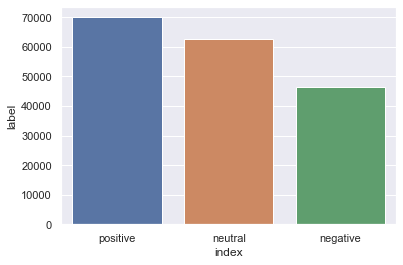

In [21]:
#label scores based on compound polarity values
labelize = lambda x: 'neutral' if x== 0 else('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)

#join two dataframes 
data = df.join(sentiment_df.label)

#plot sentiment score counts
counts_df = data.label.value_counts().reset_index()

sns.barplot(x='index',y='label',data = counts_df)

In [24]:
#aggregation
data_agg = data[['user_name','date','label']].groupby(['date','label']).count().reset_index()

data_agg.columns = ['data','label','counts']

px.line(data_agg,x='data',y='counts',color='label',title='Daily tweets sentiment analysis')
